# Setup

In [ ]:
# Install the wfdb library
!pip install wfdb wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a4bf939075c555f861b1c76bf08aea58aa1cad07ee2a1673b197f29a2f9a384c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# Plotting Assist
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import and storing/handling data
import wfdb
import numpy as np

# Signal Processing
import scipy.signal
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.model_selection import train_test_split

# Performance Metrics
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             confusion_matrix,
                             f1_score)

# Premade Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Support Vector Machine
from sklearn import svm


# Neural Network
from tensorflow import keras
from keras import layers, losses
from keras.models import Model


In [ ]:
# Set Up pyplot font and resolution settings
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 125

In [ ]:
# Install the MIT-BIH Database
wfdb.dl_database('mitdb', 'data')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

# Helper Functions



In [ ]:
# This Section sets up most of the variables and definitions needed for
# wrangling and processing the MIT-BIH database
# --------------------------------------

samplingRate = 360          # Sampling Rate of the MIT-BIH Database

# an Array containing all of the data entries of the MIT-BIH database
# * 102 and 104 do not have same channel 0 (MLII) as the rest
# * 102, 104, 107, 217 all have paced beats
# For more information on the individualities of each data Entry,
#https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#leads
dataEntries = [100, 101, 103, 105, 106, 107, 108, 109, 111, 112, 113,
               114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
               203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 221,
               222, 223, 228, 230, 231, 232, 233, 234]
invalidDataEntries = [102, 104]


# Create Class 'ECG_reading'. An ECG_reading contains the 4 most important
# values we can extract from the MIT-BIH database: the record of the reading,
# the location of the rPeaks, the labels associated with each heartbeat/peak,
# and the signal itself
class ECG_reading:
  def __init__(self, record, signal, rPeaks, labels):
    self.record = record      # Record Number in MIT-BIH databse
    self.signal = signal      # The ECG signal contained in the record
    self.rPeaks = rPeaks      # The label locations (happens to be @ rPeak loc.)
    self.labels = labels      # The labels for each heartbeat
    #self.classes = classes   # The class number associated with each label

# ----------------------------- Label Selection  -------------------------------
'''
 This is a "table" of all possible labels within the MIT-BIH database
 Simply copy and paste your desired layout into the invlaid/valid label
 variables to choose what you are trying to classify

Label   Description
'N',    # Normal heartbeat
'R',    # Right bundle branch block beat
'L',    # Left bundle branch block beat
'A',    # Atrial premature beat
'a',    # Aberrated atrial premature beat
'J',    # Nodal (junctional) premature beat
'S',    # Supraventricular premature beat
'V',    # Premature ventricular concentration
'F',    # Fusion of ventricular and normal beat
'e',    # Atrial escape beat
'j',    # Nodal (junctional) escape beat
'E',    # Ventricular escape beat
'/',    # Paced beat
'f',    # Fusion of paced and normal beat
'Q',    # Unclassifiable beat

Other, non Beat-Labels that come up,

Label   Description
'|',    # Isolated QRS-like artifact
'~',    # Change in signal quality
'+',    # Rhythm change
'[',    # Start of ventricular flutter/fibrillation
'!',    # Ventricular flutter wave
']',    # End of ventricular flutter/fibrillation
'"',    # Comment annotation
'x',    # Non-conducted P-wave (blocked APC)
'''

# While there are further labels that are used to classify beats, these are the
# only ones with enough samples within the MIT-BIH dataset to be able to train
# a NN without bootstrapping or making up data 'A' has the least data,
# with only 2452 data points
valid_labels = ['N', 'V', 'A', 'R', 'L', '/']


# Dictionary to allow for quick conversion between label and number.
# What it looks like:
# 'N' = 0,
# 'V' = 1,
# 'A' = 2,
# 'R' = 3,
# 'L' = 4,
# '/' = 5
label2Num = dict(zip(valid_labels,
                     np.arange(len(valid_labels))))

Num2Label = dict(zip(np.arange(len(valid_labels)),
                     valid_labels))

# --------------------------- End Label Selection  -----------------------------

In [ ]:
# ------------------------- Begin processRecord() ----------------------------
# Input
#   recordNum - an int number of the ECG record to be extracted (eg. '102')
# Output
#   processedSignal - an ECG_reading object (defined above) that stores the
#                     record number, rPeaks, labels, and the ECG signal itself
# Description
#   "Imports" the MIT-BIH record given and performs a first pass at signal
#   pre-processing. The pre-processing includes correcting the prelabeled
#   locations of the rPeaks to their true values, applying filtering to remove
#   noise, and normalizing the ECG signal.

def processRecord(recordNum):

    # Grab MLII readings. Easier to view Normal Beats with these readings
    rawSignal = wfdb.rdrecord(record_name = 'data/{}'.format(recordNum),
                              channels = [0]).p_signal[:,0]
    # Also, grab the corresponding annotations (labels and rPeaks)
    signalAnnotations = wfdb.rdann(record_name = 'data/{}'.format(recordNum),
                                   extension = 'atr')

    # Grab the rPeaks and the labels from the annotations
    rPeaks = signalAnnotations.sample
    labels = signalAnnotations.symbol

    # Setup a high-pass filter to remove baseline wander
    order = 2                   # Higher order not necessarily needed
    f0 = 0.5                    # toy around with. Should be good
    b, a = scipy.signal.butter(N = order, Wn = f0,
                               btype = 'highpass',
                               fs = samplingRate)
    retSignal = scipy.signal.filtfilt(b, a, rawSignal)   # Apply HP Filter

    # Setup and Apply a 60Hz notch filter to remove powerline hum
    # Second order, quality factor of 10
    f0 = 60
    b, a = scipy.signal.iirnotch(w0 = f0, Q = 10, fs = samplingRate)
    retSignal = scipy.signal.filtfilt(b, a, retSignal)    # Apply Notch

    # Normalize Signal
    retSignal = retSignal.reshape(len(retSignal),1)
    scaler = MinMaxScaler()
    scaledSignal = scaler.fit_transform(retSignal)
    scaledSignal = scaledSignal.reshape(len(retSignal))

    return (ECG_reading(recordNum, scaledSignal, rPeaks, labels))
# ------------------------- End of processRecord -----------------------------

In [ ]:
# ----------------------- Begin removeInvalidPeaks() -------------------------
# Input
#   reading - the ECG_reading type object with the sig whose peaks r2b removed
#   valid_labels - an array containing the valid labels (as strings or chars)
# Output
#   abridgedSignal - an ECG_reading type object containing the same signal
#                    passed to the function, rPeaks and labels filtered for only
#                    those associated with valid labels
# Description
#   This function does not alter the ECG signal in any way. Instead, it searches
#   through the rPeaks and the associated labels and removes any that contain an
#   invalid label. Therefore, the ECG_reading object returned contains the same
#   signal and record as the passed object, with only the rPeaks and labels
#   altered.

def removeInvalidPeaks(reading, valid_labels):
    labels = np.array(reading.labels)
    rPeaks = np.array(reading.rPeaks)
    validated_labels = []
    validated_rPeaks = []

    for peakNum in np.arange(1, len(rPeaks) - 1):
        if (labels[peakNum] not in valid_labels):
            continue
        validated_rPeaks.append(rPeaks[peakNum])
        validated_labels.append(labels[peakNum])

    return (ECG_reading(reading.record,
                        reading.signal,
                        validated_rPeaks,
                        validated_labels))

# ----------------------- End removeInvalidPeaks() ---------------------------

In [ ]:
# ----------------------- Begin segmentSignal() -------------------------
# Input
#   record - the ECG_reading type object with the signal to be
# Output
#   newSignal - an array of 300 sample long segments (each 1 heartbeat)
#   cl_labels - an array of values 0-5 that numerically represent 1/6 conditions
#               Used with Premade Classifiers.
#   nn_labels - an array of 6 wide arrays that are filled with 0s except for a 1
#                in the pos. of condition. Used with Neural Net
#   classes   - All the original labels associated w/ each heartbeat (letters)
# Description
#   This function does 4 things. First, it segments/cuts the input ECG Signal
#   into its individual heartbeats. These heartbeats are then returned in an
#   array. Second, this function removes any heartbeats that have invalid labels
#   Third, it converts the labels from letters into numbers. Fourth, it randomly
#   undersamples "Normal" heartbeats so to balance the remaining data.
#   (This is actually just more signal processing, NOT feature extraction)

def segmentSignal(record):

    # First grab rPeaks, labels, and the signal itself from the record
    labels = record.labels
    rPeaks = np.array(record.rPeaks)
    signal = record.signal

    # How many samples to grab before and after the QRS complex.
    preBuffer = 150
    postBuffer = 150

    # arrays to be returned
    newSignal = []
    cl_Labels = []
    classes = []

    # iterate through all rPeaks. If the label is not valid, skip that peak
    for peakNum in range(1,len(rPeaks)):

        if labels[peakNum] not in valid_labels:
            continue

        # Ensure that we do not grab an incomplete QRS complex
        lowerBound = rPeaks[peakNum] - preBuffer
        upperBound = rPeaks[peakNum] + postBuffer
        if ((lowerBound < 0) or (upperBound > len(signal))):
            continue

        # Randomly undersample from all Normal heartbeats
        if labels[peakNum] == 'N':
            if random.uniform(0,1) < 0.85:
                continue

        # if it is valid, grab the 150 samples before and 149 samples after peak
        QRS_Complex = signal[lowerBound:upperBound]

        # Fix the corresponding labels to the data
        newSignal.append(QRS_Complex)
        cl_Labels.append(label2Num[labels[peakNum]])

        classes.append(labels[peakNum])

    return newSignal, cl_Labels, classes

In [ ]:
# ---------------------------- Begin print_stats() ----------------------------
# Input
#   predictions - the predicted classes
#   labels - the actual classes
# Output
#   (No Outputs)
# Description
#   Helper function that expedites performance analysis by calculating accuracy,
#   precision, recall, and F1 score given predictions and true values. It then
#   prints the results.

def print_stats(predictions, labels):
  print("Accuracy = {0:.1f}%".format(accuracy_score(labels,
                                                    predictions)*100))

  print("Precision = {0:.1f}%".format(precision_score(labels,
                                                      predictions,
                                                      average = 'macro')*100))

  print("Recall = {0:.1f}%".format(recall_score(labels,
                                                predictions,
                                                average = 'macro')*100))

  print("F1 Score = {0:.1f}%".format(f1_score(labels,
                                              predictions,
                                              average = 'macro')*100))

In [ ]:
# ----------------------- Begin showConfusionMatrix() -------------------------
# Input
#   predictions - the predicted classes
#   labels - the actual classes
# Output
#   (No Outputs)
# Description
#   This function creates a good looking confusion matrix. Tailored for
#   6 classes (N, V, A, R, L, /) from the MIT-BIH database. the tick labels
#   would need to be changed in order to use with other classes.


colors = ['#ffffff', '#ffffff']#DCDCDC', '#D3D3D3', '#C0C0C0', '#A9A9A9']

def showConfusionMatrix(predictions, labels):
    # Create Confusion Matrix
    cfm_data = confusion_matrix(labels, predictions)
    '''
    cf_matrix = sns.heatmap(cfm_data, fmt='d', annot=True, square=True,
                            cmap='gray_r', vmin=0, vmax=0,  # set all to white
                            linewidths=0.5, linecolor='k',  # draw black grid
                            cbar=False)                     # disable colorbar
    '''

    #sns.set_palette(sns.color_palette(colors, as_cmap = True))

    cf_matrix = sns.heatmap(cfm_data, annot=True, fmt = '.0f', square = True,
                            cmap = sns.color_palette(colors, as_cmap = True),
                            linewidths = 0.5, linecolor = 'k', cbar = False)

    # Apply Axis Formatting
    cf_matrix.set_xlabel("Predicted Classification")
    cf_matrix.set_ylabel("Actual Classification")
    cf_matrix.xaxis.set_ticklabels(["N", "V","A","R","L","/"])
    cf_matrix.yaxis.set_ticklabels(["N", "V","A","R","L","/"])

    # Display Confusion Matrix
    plt.show()

In [ ]:
# Plots the First Waveform of a given classification given record number and
# Classification
def plotWaveformByClass(record, classification):
    rec = processRecord(record)

    testLabels = np.array(rec.labels)
    classIndex = np.where(testLabels == classification)

    classIndex = classIndex[0]
    if np.size(classIndex) == 0:
        print("Classification is not present in given ECG Recording")
        return

    # Protects against overflowing bounds
    for Index in classIndex:
        print(Index)
        tPeak = rec.rPeaks[Index]
        lowerBound = tPeak - 150
        upperBound = tPeak + 150
        if ((lowerBound < 0) or (upperBound > len(rec.signal))):
            continue
        else:
            break

    waveform = rec.signal[lowerBound:upperBound]
    plt.subplot(2,1,2)
    plt.plot(np.arange(len(waveform)), waveform, c = '#355E3B')
    plt.xlabel("Sample")
    # plt.ylabel("Normalized Voltage")

In [ ]:
# Plots the First Waveform of a given classification given record number and
# Classification
def plotWaveformByIndex(record, index):

    # grab record by given number
    rec = processRecord(record)

    # Grab a the given heartbeat (by index)
    tPeak = rec.rPeaks[index]
    lowerBound = tPeak - 150
    upperBound = tPeak + 150

    # Protect against over-reaching bounds
    if (lowerBound < 0):
        lowerBound = 0
    if (upperBound > len(rec.signal)):
        upperBound = len(rec.signal)

    waveform = rec.signal[lowerBound:upperBound]
    plt.plot(np.arange(len(waveform)), waveform)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Voltage (mV/mV)")

# Data Wrangling

In [ ]:
# Process All records and consolidate data into a "single" data structure
X = []                  # Input Signals, array of 300 length arrays
Y_cl = []               # Num b/w 0 - 5 associated with particular class
Y =[]
Z = []                  # The Letterlabel
nn_label_temp = []

# Process All records
for record in dataEntries:
    rec = (processRecord(record))
    tX, tY, tZ = segmentSignal(rec)
    X.extend(tX)
    Y_cl.extend(tY)
    # Y_nn.extend(tY2)
    Z.extend(tZ)

# Convert to numpy array for ease of use
X = np.array(X)
Y_cl = np.array(Y_cl)
Z = np.array(Z)

recLabels, labelCounts = np.unique(Y_cl, return_counts= True)
label_dict = dict(zip(recLabels, labelCounts))

print(label_dict)
print(Y_cl.shape)

{0: 10867, 1: 7123, 2: 2452, 3: 7255, 4: 8071, 5: 3619}
(39387,)


In [ ]:
# Split into train/test data for the premade classifiers
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, Y_cl,
                                                    test_size = 0.10,
                                                    random_state = 12)

print(X_train.shape, y_cl_train.shape, X_test.shape,  y_cl_test.shape)

# Print Training + Validation Class Breakdown
recLabels, labelCounts = np.unique(y_cl_train, return_counts= True)
label_dict = dict(zip(recLabels, labelCounts))
print(label_dict)

# Print Test Data Class Breakdown
recLabels, labelCounts = np.unique(y_cl_test, return_counts= True)
label_dict = dict(zip(recLabels, labelCounts))
print(label_dict)

# Further split the training data into training/validity
X_train, X_valid, y_cl_train, y_cl_valid = train_test_split(X_train, y_cl_train,
                                                    test_size = 0.10,
                                                    random_state = 87)

print(X_train.shape, y_cl_train.shape, X_valid.shape,  y_cl_valid.shape)

(35448, 300) (35448,) (3939, 300) (3939,)
{0: 9778, 1: 6400, 2: 2224, 3: 6504, 4: 7295, 5: 3247}
{0: 1089, 1: 723, 2: 228, 3: 751, 4: 776, 5: 372}
(31903, 300) (31903,) (3545, 300) (3545,)


In [ ]:
# Create NN Classifier Test data from
y_nn_test = []
y_nn_train = []
y_nn_valid = []

for label in y_cl_train:
    nn_Labels_temp = [0, 0, 0, 0, 0, 0]
    nn_Labels_temp[label] = 1

    y_nn_train.append(nn_Labels_temp)

for label in y_cl_test:
    nn_Labels_temp = [0, 0, 0, 0, 0, 0]
    nn_Labels_temp[label] = 1

    y_nn_test.append(nn_Labels_temp)

for label in y_cl_valid:
    nn_Labels_temp = [0, 0, 0, 0, 0, 0]
    nn_Labels_temp[label] = 1

    y_nn_valid.append(nn_Labels_temp)

y_nn_test = np.array(y_nn_test)
y_nn_train = np.array(y_nn_train)
y_nn_valid = np.array(y_nn_valid)
print(y_nn_train.shape, y_nn_test.shape, y_nn_valid.shape)

(31903, 6) (3939, 6) (3545, 6)


# Classifiers In Boxes

In [ ]:
## DUMMY CLASSIFIER ##
# Start with the most basic classifier, 'Dummy Classifier', which makes
# predicitions by ignoring input features
classifier = DummyClassifier(strategy = 'prior')
classifier.fit(X_train, y_cl_train)

print("Accuracy Results")
y_pred = classifier.predict(X_train)
print_stats(y_pred, y_cl_train)

print("\nValidation Results")
y_pred = classifier.predict(X_valid)
print_stats(y_pred, y_cl_valid)

print("\nTest Results")
y_pred = classifier.predict(X_test)
print_stats(y_pred, y_cl_test)

# Plot Confusion Matrix for Dummy Classifier
showConfusionMatrix(y_pred, y_cl_test)

In [ ]:
## RANDOM FOREST ##
# (non-time based) Classifier which utilizes decision tree-based model
classifier = RandomForestClassifier()
classifier.fit(X_train, y_cl_train)

# Make Predicions with Random Forest Classifier
print("Training Performance")
y_pred = classifier.predict(X_train)
print_stats(y_pred, y_cl_train)

print("\nValidation Performance")
y_pred = classifier.predict(X_valid)
print_stats(y_pred, y_cl_valid)

print("\nTest Data Performance")
y_pred = classifier.predict(X_test)
print_stats(y_pred, y_cl_test)

# Plot Confusion Matrix for Random Forest Classifier
showConfusionMatrix(y_pred, y_cl_test)

Training Performance
Accuracy = 99.0%
Precision = 99.1%
Recall = 98.5%
F1 Score = 98.8%

Validation Performance
Accuracy = 98.6%
Precision = 98.4%
Recall = 97.7%
F1 Score = 98.1%

Test Data Performance
Accuracy = 99.0%
Precision = 98.9%
Recall = 98.2%
F1 Score = 98.6%


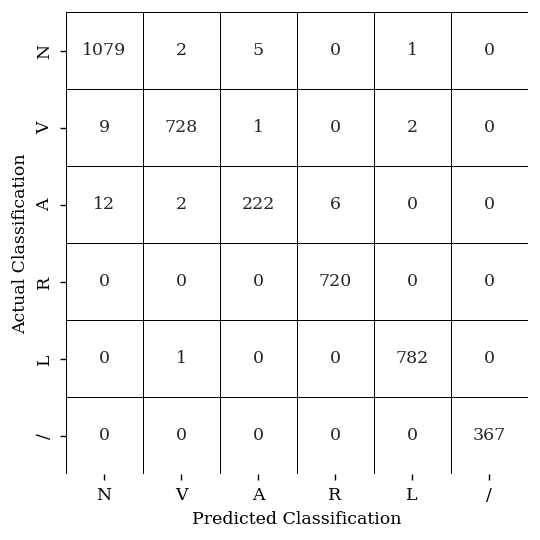

In [ ]:
## K-th NEAREST NEIGHBOR ##
# Classifies based on proximity to other classified data
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_cl_train)

# Performance of KNN Classifier
print("Training Performance")
y_pred = classifier.predict(X_train)
print_stats(y_pred, y_cl_train)

print("\nValidation Performance")
y_pred = classifier.predict(X_valid)
print_stats(y_pred, y_cl_valid)

print("\nTest Data Performance")
y_pred = classifier.predict(X_test)
print_stats(y_pred, y_cl_test)

# Plot Confusion Matrix for Kth Nearest Neighbor
showConfusionMatrix(y_pred, y_cl_test)

#-------------------------End Classifiers in Boxes------------------------------

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_cl_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# The Neural Network

In [ ]:
# Convolutional Neural Network Definition

# Clear older models, prevents lag/bloat
keras.backend.clear_session()

# specify processed data information
n_timesteps = X_train.shape[1]
n_features = 1
n_outputs = 6

# Construct CNN

# Block 1
CNN = keras.models.Sequential()
CNN.add(layers.Conv1D(filters= 32,
                      kernel_size= 3,
                      input_shape=(n_timesteps,n_features),
                      activation='relu',
                      name = "Conv1",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.Conv1D(filters = 32,
                      kernel_size = 3,
                      activation='relu',
                      name = "Conv2",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.MaxPooling1D(pool_size=3))
CNN.add(layers.Dropout(0.1))

# # Block 2
CNN.add(layers.Conv1D(filters= 64,
                      kernel_size= 3,
                      activation='relu',
                      name = "Conv3",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.Conv1D(filters = 64,
                      kernel_size = 3,
                      activation='relu',
                      name = "Conv4",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Dropout(0.1))

# Block 3
CNN.add(layers.Conv1D(filters = 128,
                      kernel_size= 3,
                      activation='relu',
                      name = "Conv5",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.Conv1D(filters = 128,
                      kernel_size = 3,
                      activation='relu',
                      name = "Conv6",
                      padding = "same",
                      strides = 1
                      ))
CNN.add(layers.MaxPooling1D(pool_size=5))

CNN.add(layers.Flatten())
#CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(n_outputs, activation='softmax'))

# Compile Model
CNN.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics = ["accuracy"])

In [ ]:
# Use to Visualize Neural Network Topology and Trainable Parameters
print(CNN.summary())

# keras.utils.plot_model(CNN,
#                        show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv1D)              (None, 300, 32)           128       
                                                                 
 Conv2 (Conv1D)              (None, 300, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 32)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 Conv3 (Conv1D)              (None, 100, 64)           6208      
                                                                 
 Conv4 (Conv1D)              (None, 100, 64)           12352     
                                                        

In [ ]:
# Train CNN
history = CNN.fit(X_train,
                    y_nn_train,
                    epochs= 20,
                    validation_data = (X_valid, y_nn_valid),
                    batch_size= 512,
                    shuffle = True,
                    verbose= 1)

Epoch 1/20
63/63 [==============================] - 15s 18ms/step - loss: 1.4989 - accuracy: 0.3774 - val_loss: 0.8694 - val_accuracy: 0.7109
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5463 - accuracy: 0.8256 - val_loss: 0.2823 - val_accuracy: 0.9176
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 0.2507 - accuracy: 0.9326 - val_loss: 0.1398 - val_accuracy: 0.9622
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.1573 - accuracy: 0.9572 - val_loss: 0.1026 - val_accuracy: 0.9698
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.1257 - accuracy: 0.9655 - val_loss: 0.0924 - val_accuracy: 0.9746
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.1100 - accuracy: 0.9703 - val_loss: 0.0870 - val_accuracy: 0.9752
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0896 - accuracy: 0.9754 - val_loss: 0.0595 - val_accuracy: 0.9822
Epoch 8/20
63/63 

Training Data Performance
997/997 [==============================] - 2s 2ms/step
Accuracy = 99.1%
Precision = 98.7%
Recall = 98.7%
F1 Score = 98.7%


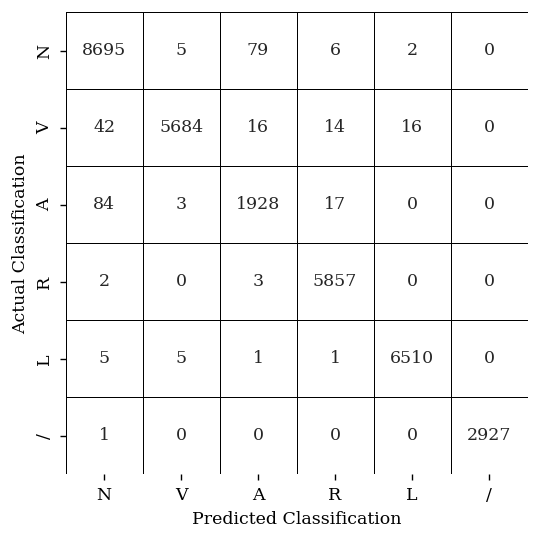



Validation Data Performance
111/111 [==============================] - 0s 2ms/step
Accuracy = 98.8%
Precision = 98.3%
Recall = 98.2%
F1 Score = 98.3%


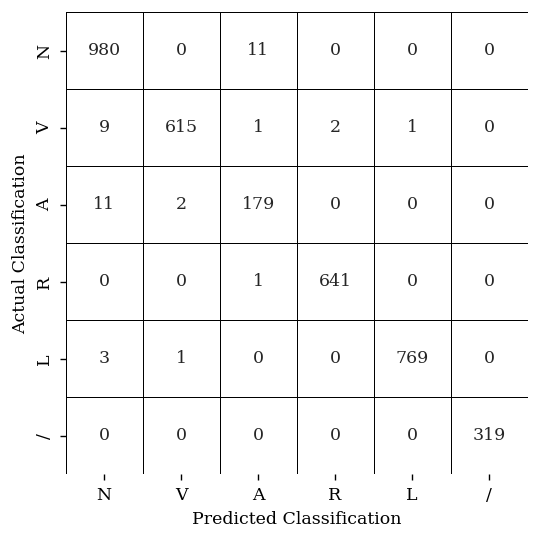



Test Data Performance
124/124 [==============================] - 0s 2ms/step
Accuracy = 98.9%
Precision = 98.7%
Recall = 98.3%
F1 Score = 98.5%


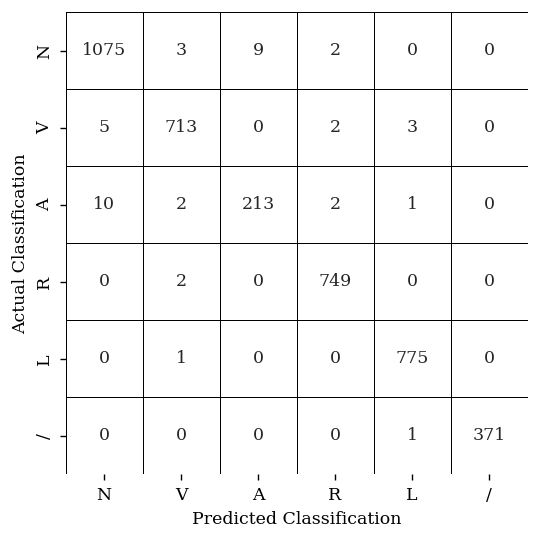

In [ ]:
# Make predictions with trained CNN, using the test data

print("Training Data Performance")
y_preds = CNN.predict(X_train)
y_pm = np.argmax(y_preds, axis = 1)        # Single Class Predictions
y_tm = np.argmax(y_nn_train, axis = 1)     # Single Class Test Labels
print_stats(y_pm, y_tm)
showConfusionMatrix(y_pm, y_tm)

print("\n")
print("Validation Data Performance")
y_preds = CNN.predict(X_valid)
y_pm = np.argmax(y_preds, axis = 1)        # Single Class Predictions
y_tm = np.argmax(y_nn_valid, axis = 1)     # Single Class Test Labels
print_stats(y_pm, y_tm)
showConfusionMatrix(y_pm, y_tm)

# Make predictions with trained CNN, using the test data

print("\n")
print("Test Data Performance")
y_preds = CNN.predict(X_test)

# Convert Multiclass to single class for performance analysis
y_pm = np.argmax(y_preds, axis = 1)        # Single Class Predictions
y_tm = np.argmax(y_nn_test, axis = 1)      # Single Class Test Labels

# Performance of CNN
print_stats(y_pm, y_tm)
showConfusionMatrix(y_pm, y_tm)

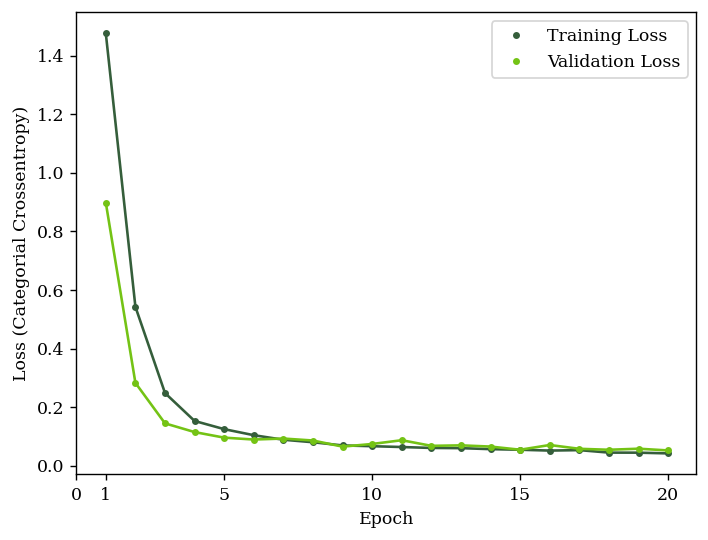

In [ ]:
# View Loss results

# Training Loss
y = np.array(history.history["loss"])
x = np.arange(len(y))
x += 1
plt.plot(x, y, c = '#355E3B')
plt.plot(x, y, '.', label="Training Loss", c = '#355E3B')


# Validation Loss
y2 = np.array(history.history["val_loss"])
x2 = np.arange(len(y2))
x2 += 1
plt.plot(x2, y2, c = '#74C315')
plt.plot(x2, y2, '.', label="Validation Loss", c = '#74C315')

# Make Pretty
plt.xlabel("Epoch")
plt.xticks([0, 1, 5,10,15,20])
plt.ylabel("Loss (Categorial Crossentropy)")
plt.legend()

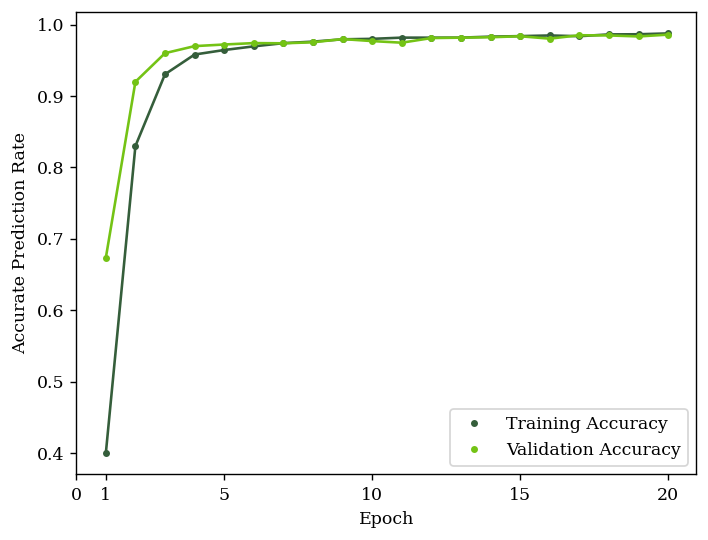

In [ ]:
# View Accuracy results

# Training Accuracy
y = np.array(history.history["accuracy"])
x = np.arange(len(y))
x += 1
plt.plot(x, y, c = '#355E3B')
plt.plot(x, y, '.', label="Training Accuracy", c = '#355E3B')

# Validation Loss
y2 = np.array(history.history["val_accuracy"])
x2 = np.arange(len(y2))
x2 += 1
plt.plot(x2, y2, c = '#74C315')
plt.plot(x2, y2, '.', label="Validation Accuracy", c = '#74C315')

# Make Pretty
plt.xlabel("Epoch")
plt.xticks([0, 1, 5,10,15,20])
plt.ylabel("Accurate Prediction Rate")
plt.legend()

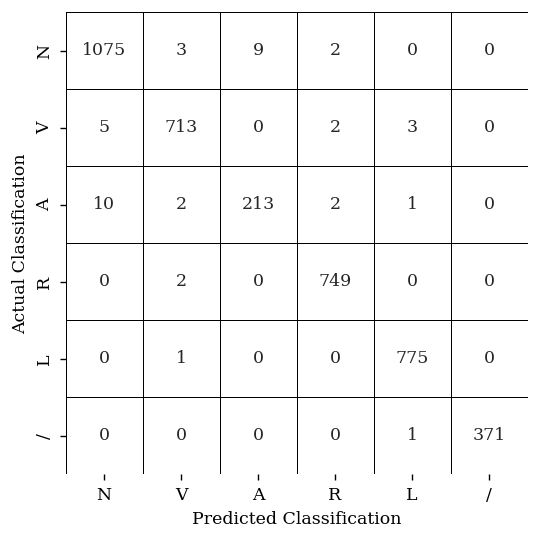

In [ ]:
# Create Confusion Matrix
showConfusionMatrix(y_pm, y_tm)

# Extras


In [ ]:
# Check for all labels within MIT-BIH database
all_labels = []

# Process All labels
for record in dataEntries:
    rec = processRecord(record)
    all_labels.extend(rec.labels)
    recLabels, labelCounts = np.unique(rec.labels, return_counts= True)
    print(rec.record, recLabels, labelCounts)

# Check for unique labels
all_labels = np.array(all_labels)
recLabels, labelCounts = np.unique(all_labels, return_counts= True)

# Create Dict to make viewing easier
label_dict = dict(zip(recLabels, labelCounts))

print("\n","All labels in MIT-BIH + Counts:")
print(label_dict)

100 ['+' 'A' 'N' 'V'] [   1   33 2239    1]
101 ['+' 'A' 'N' 'Q' '|' '~'] [   1    3 1860    2    4    4]
103 ['+' 'A' 'N' '~'] [   1    2 2082    6]
105 ['+' 'N' 'Q' 'V' '|' '~'] [   1 2526    5   41   30   88]
106 ['+' 'N' 'V' '~'] [  41 1507  520   30]
107 ['+' '/' 'V' '~'] [   1 2078   59    2]
108 ['+' 'A' 'F' 'N' 'V' 'j' 'x' '|' '~'] [   1    4    2 1739   17    1   11    8   41]
109 ['+' 'F' 'L' 'V' '~'] [   1    2 2492   38    2]
111 ['+' 'L' 'V' '~'] [   1 2123    1    8]
112 ['+' 'A' 'N' '~'] [   1    2 2537   10]
113 ['+' 'N' 'a'] [   1 1789    6]
114 ['+' 'A' 'F' 'J' 'N' 'V' '|' '~'] [   3   10    4    2 1820   43    1    7]
115 ['+' 'N' '|' '~'] [   1 1953    6    2]
116 ['+' 'A' 'N' 'V' '~'] [   1    1 2302  109    8]
117 ['+' 'A' 'N' '~'] [   1    1 1534    3]
118 ['+' 'A' 'R' 'V' 'x' '~'] [   1   96 2166   16   10   12]
119 ['+' 'N' 'V' '~'] [ 103 1543  444    4]
121 ['+' 'A' 'N' 'V' '~'] [   1    1 1861    1   12]
122 ['+' 'N' '|'] [   1 2476    2]
123 ['+' 'N' 'V'] [ 

1587


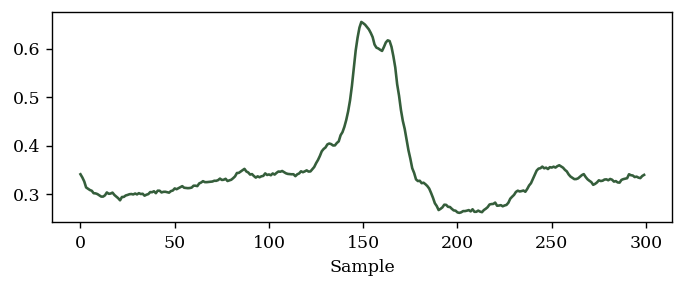

In [ ]:
plotWaveformByClass(234, 'V')

1
2


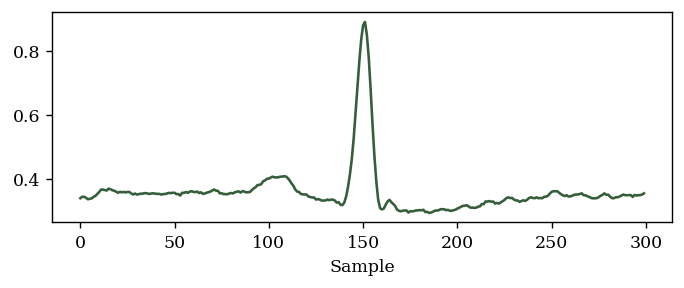

In [ ]:
plotWaveformByClass(234,'N')